In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#ucimlrepo is for the data
from ucimlrepo import fetch_ucirepo 

In [5]:
 # Fetch the Breast Cancer Wisconsin dataset from UCI repository
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Get the features (X) and targets (y) as pandas DataFrames
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Print columns to verify the structure
#print("Feature columns:\n", X.columns)
#print("Target columns:\n", y.columns)

y = y.iloc[:, 0]  # extract the Series

# Map the diagnosis labels: 1 for malignant ('M'), 0 for benign ('B')
y = y.map({'M': 1, 'B': 0})  # Adjust this mapping as per the dataset's structure

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the input dimension
input_dim = X_train.shape[1]

Epoch 1/10
15/15 [==============================] - 0s 6ms/step - loss: 59483.8516 - accuracy: 0.6308 - val_loss: 62.7568 - val_accuracy: 0.6228
Epoch 2/10
15/15 [==============================] - 0s 2ms/step - loss: 79.1918 - accuracy: 0.6308 - val_loss: 1322.1158 - val_accuracy: 0.6228
Epoch 3/10
15/15 [==============================] - 0s 2ms/step - loss: 57.8940 - accuracy: 0.6286 - val_loss: 662.8934 - val_accuracy: 0.6228
Epoch 4/10
15/15 [==============================] - 0s 2ms/step - loss: 32.6324 - accuracy: 0.6264 - val_loss: 1968.3503 - val_accuracy: 0.6228
Epoch 5/10
15/15 [==============================] - 0s 2ms/step - loss: 27.0240 - accuracy: 0.6264 - val_loss: 1445.0834 - val_accuracy: 0.6228
Epoch 6/10
15/15 [==============================] - 0s 2ms/step - loss: 26.3485 - accuracy: 0.6242 - val_loss: 1478.4342 - val_accuracy: 0.6228
Epoch 7/10
15/15 [==============================] - 0s 2ms/step - loss: 25.1180 - accuracy: 0.6220 - val_loss: 922.2916 - val_accuracy: 

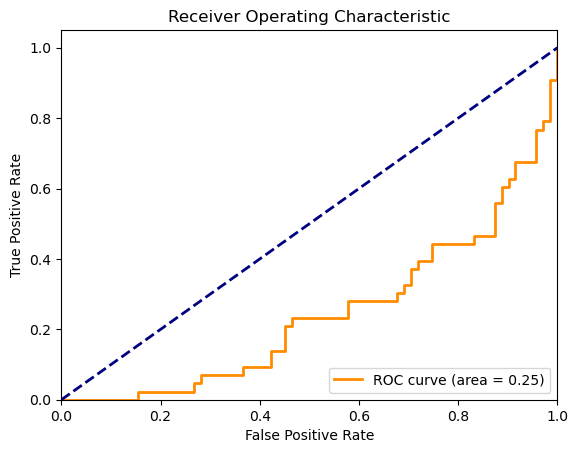

In [19]:


# Define the model architecture
autoencoder_pos = Sequential([
    Dense(14, activation='relu', input_shape=(input_dim,)),
    Dense(7, activation='relu'),
    Dense(14, activation='relu'),
    Dense(1)  # Assuming a single output for regression
])

# Define a custom loss function for the positive model
def custom_loss_pos(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    modified_loss = tf.where(tf.equal(y_true, 1), mse ** 1, mse ** -1)
    return modified_loss

# Define a custom loss function for the negative model
def custom_loss_neg(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    modified_loss = tf.where(tf.equal(y_true, 1), mse ** -1, mse ** 1)
    return modified_loss

# Compile the models with the Adam optimizer and MSE loss function
autoencoder_pos.compile(optimizer='adam', loss=custom_loss_pos, metrics=['accuracy'])
autoencoder_neg.compile(optimizer='adam', loss=custom_loss_neg, metrics=['accuracy'])


# Train the models
autoencoder_pos.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
autoencoder_neg.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



# Generate predictions
y_pred_prob = autoencoder_pos.predict(X_test).ravel()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
